# NLP/LLM Engineer Test - Medical Fine-tuning

This notebook demonstrates the complete solution for the NLP/LLM Engineer test.
It covers:
1.  **Setup & Configuration**: Environment and hyperparameters.
2.  **Training**: Fine-tuning Qwen2.5-1.5B-Instruct on a medical dataset using LoRA.
3.  **Evaluation**: Comparing different LoRA configurations (r=8, 16, 32).
4.  **Inference**: Demonstrating the best model on diverse medical queries.


## 1. Setup & Dependencies


In [1]:
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import sys
import os
import yaml
import torch
from IPython.display import Markdown, display, Image
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

# Add project root to path
sys.path.append(os.path.abspath("../"))
from src.utils.env_utils import setup_env

setup_env()
print("Environment setup complete.")


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setting HF_HOME to ./hf_cache
W&B API Key found.
Environment setup complete.


## 2. Configuration
We use `configs/config.yml` to manage all hyperparameters.


In [3]:
with open("../configs/config.yml", "r") as f:
    config = yaml.safe_load(f)
    print(yaml.dump(config, default_flow_style=False))


dataset:
  instruction_template: '<|im_start|>system

    You are a helpful medical assistant.<|im_end|>

    <|im_start|>user

    {question}<|im_end|>

    <|im_start|>assistant

    {answer}<|im_end|>

    '
  max_samples: 5000
  name: ruslanmv/ai-medical-chatbot
  seed: 42
  shuffle: true
  train_ratio: 0.9
  val_ratio: 0.1
evaluation:
  test_questions:
  - What are the symptoms of diabetes?
  - How to treat a common cold?
  - What causes high blood pressure?
  - What are the side effects of aspirin?
  - How to prevent heart disease?
  - What should I do if I have chest pain?
  - How can I lower my cholesterol naturally?
  - What are the early signs of cancer?
experiments:
- lora:
    lora_alpha: 32
    lora_dropout: 0.2
    r: 16
  name: lora_r16_alpha32_v3
- lora:
    lora_alpha: 32
    lora_dropout: 0.2
    r: 16
  name: lora_r16_alpha32_lowlr
  training:
    learning_rate: 5.0e-05
- lora:
    lora_alpha: 64
    lora_dropout: 0.25
    r: 32
  name: lora_r32_alpha64_v2
lora:
  bi

## 3. Training & Comparison
We run `scripts/train_comparison.py` to train multiple LoRA configurations and compare them.
**Note**: This step may take significant time. If models are already trained, it will skip training and generate reports.


In [4]:
!python ../scripts/train_comparison.py

INFO     2025-12-01 04:40:48 - setup - INFO - Logging initialized. Log file:    
         logs/project_20251201_044048.log                                       
╭──────────────────────────────────────────────────────────────────────────────╮
│ Running LoRA Experiments (Subprocess)                                        │
╰──────────────────────────────────────────────────────────────────────────────╯
INFO     2025-12-01 04:40:48 - __main__ - INFO - Checking for results in:       
         /home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/outputs/lor
         a_r16_alpha32_v3                                                       
INFO     2025-12-01 04:40:48 - __main__ - INFO - Experiment lora_r16_alpha32_v3 
         already completed. Skipping training.                                  


INFO     2025-12-01 04:40:49 - __main__ - INFO - Checking for results in:       
         /home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/outputs/lor
         a_r16_alpha32_lowlr                                                    
INFO     2025-12-01 04:40:49 - __main__ - INFO - Experiment                     
         lora_r16_alpha32_lowlr already completed. Skipping training.           


INFO     2025-12-01 04:40:49 - __main__ - INFO - Checking for results in:       
         /home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/outputs/lor
         a_r32_alpha64_v2                                                       
INFO     2025-12-01 04:40:49 - __main__ - INFO - Experiment lora_r32_alpha64_v2 
         already completed. Skipping training.                                  


Traceback (most recent call last):
  File "/home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/notebooks/../scripts/train_comparison.py", line 236, in <module>
    run_experiments()
    ~~~~~~~~~~~~~~~^^
  File "/home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/notebooks/../scripts/train_comparison.py", line 233, in run_experiments
    generate_report(results)
    ~~~~~~~~~~~~~~~^^^^^^^^^
  File "/home/thanhnx/qwen/finetune-qwen2.5-1.5b-ai-medical-chatbot/notebooks/../scripts/train_comparison.py", line 49, in generate_report
    with open(output_file, "w") as f:
         ~~~~^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'outputs/experiment_report.md'


## 4. Analysis & Results
Here is the summary of our experiments.


In [5]:
report_path = "../outputs/experiment_report.md"
if os.path.exists(report_path):
    with open(report_path, "r") as f:
        display(Markdown(f.read()))
else:
    print("Report not found. Please run training first.")


Report not found. Please run training first.


### Loss Curves
Visualizing the training stability.


#### lora_r16_alpha32_lowlr

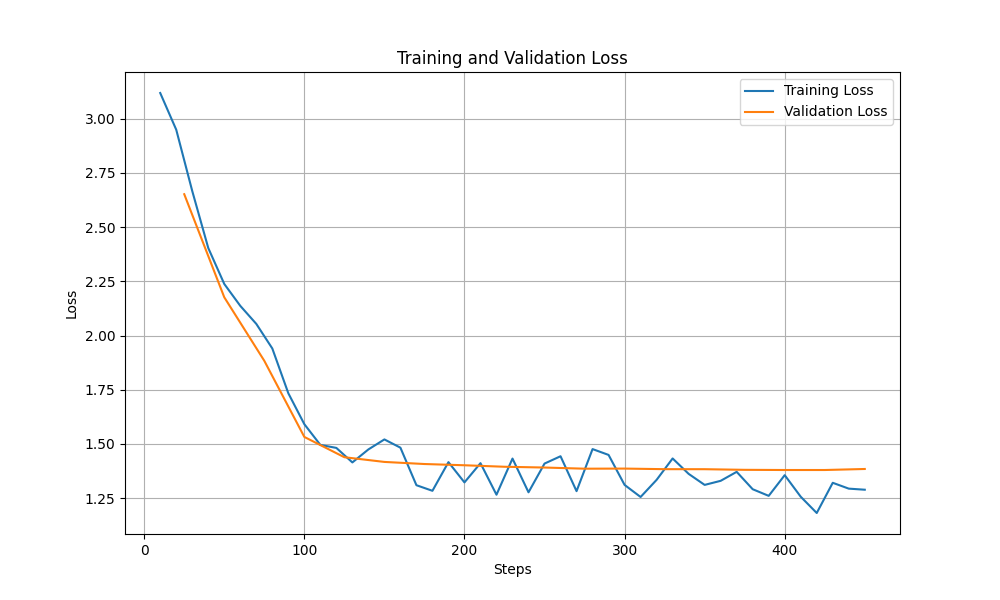

#### lora_r16_alpha32_v3

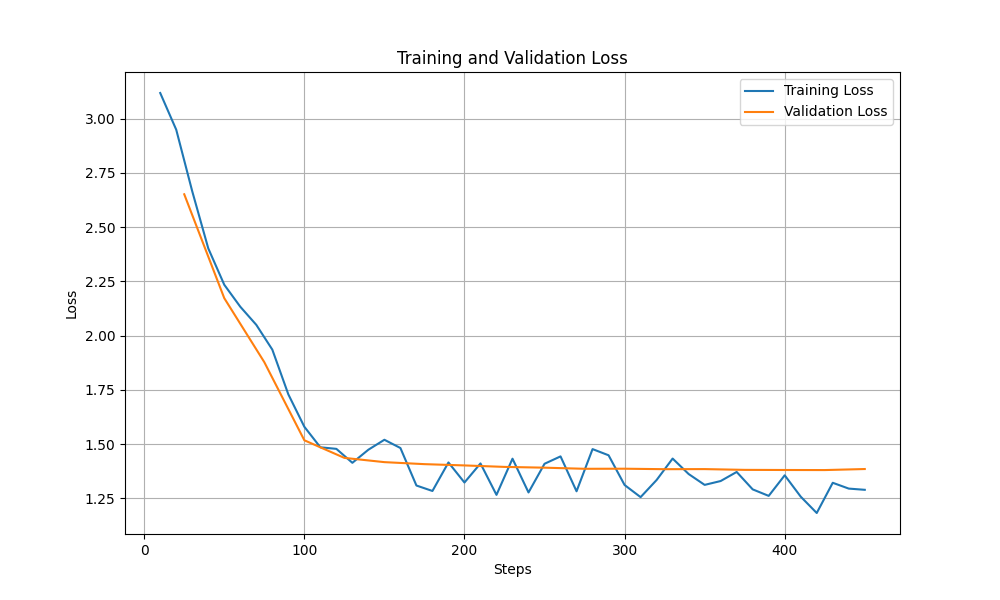

#### lora_r32_alpha64_v2

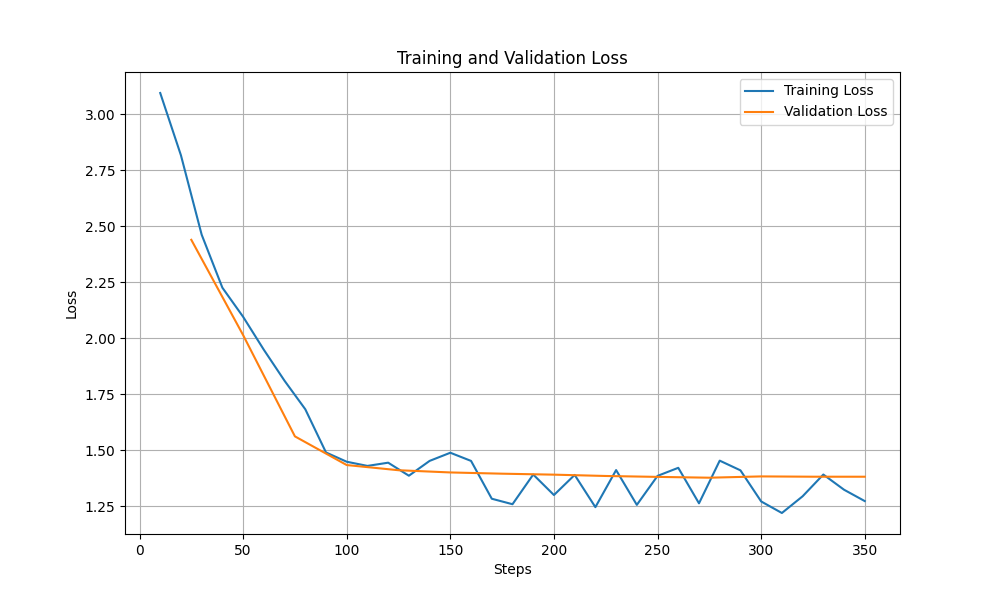

In [6]:
# Display loss curves for all experiments (dynamic detection)
outputs_dir = "../outputs"
displayed = False

for exp in sorted(os.listdir(outputs_dir)):
    if exp.startswith('.') or exp == 'outputs_old':
        continue
    img_path = os.path.join(outputs_dir, exp, "loss_curve.png")
    if os.path.exists(img_path):
        display(Markdown(f"#### {exp}"))
        display(Image(filename=img_path))
        displayed = True

if not displayed:
    print("No loss curves found. Please run training first.")

## 5. Comparative Inference
We compare the generation quality of different LoRA configurations (e.g., r=8, r=16, r=32) on the same set of questions.


In [7]:
# Load Base Model Once
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

print(f"Loading base model: {model_name}...")
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)
print("Base model loaded.")

def generate_response(model, question, max_new_tokens=256):
    prompt = f"<|im_start|>system\nYou are a helpful medical assistant.<|im_end|>\n<|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True
        )
    
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

# Test Questions for Comparison
comparison_questions = [
    "What are the symptoms of diabetes?",
    "How to treat a common cold?"
]

# Find available experiments with final_checkpoint
outputs_dir = "../outputs"
available_experiments = []
for exp in os.listdir(outputs_dir):
    exp_path = os.path.join(outputs_dir, exp)
    if os.path.isdir(exp_path) and exp != 'outputs_old':
        adapter_path = os.path.join(exp_path, "final_checkpoint")
        if os.path.exists(adapter_path) and os.path.exists(os.path.join(adapter_path, "adapter_config.json")):
            available_experiments.append(exp)

print(f"Found {len(available_experiments)} trained experiments: {available_experiments}")

if available_experiments:
    results = {}
    model = None
    
    for i, exp in enumerate(available_experiments):
        adapter_path = f"../outputs/{exp}/final_checkpoint"
        
        if i == 0:
            # Initialize PeftModel with the first adapter
            print(f"Initializing PeftModel with {exp}...")
            model = PeftModel.from_pretrained(base_model, adapter_path, adapter_name=exp)
        else:
            print(f"Loading adapter: {exp}...")
            model.load_adapter(adapter_path, adapter_name=exp)
            
        print(f"Switching to adapter: {exp}")
        model.set_adapter(exp)
        
        print(f"Generating responses for {exp}...")
        exp_results = []
        for q in comparison_questions:
            ans = generate_response(model, q)
            exp_results.append(ans)
        results[exp] = exp_results

    # Print Comparison
    for i, q in enumerate(comparison_questions):
        print(f"\n=== Question: {q} ===")
        for exp, answers in results.items():
            print(f"\n[{exp}]:\n{answers[i]}")
            print("-" * 30)
else:
    print("No trained experiments found. Please run training first.")
    model = None

Loading base model: Qwen/Qwen2.5-1.5B-Instruct...


Base model loaded.
Found 3 trained experiments: ['lora_r16_alpha32_v3', 'lora_r16_alpha32_lowlr', 'lora_r32_alpha64_v2']
Initializing PeftModel with lora_r16_alpha32_v3...


Switching to adapter: lora_r16_alpha32_v3
Generating responses for lora_r16_alpha32_v3...


Loading adapter: lora_r16_alpha32_lowlr...
Switching to adapter: lora_r16_alpha32_lowlr
Generating responses for lora_r16_alpha32_lowlr...


Loading adapter: lora_r32_alpha64_v2...


Switching to adapter: lora_r32_alpha64_v2
Generating responses for lora_r32_alpha64_v2...



=== Question: What are the symptoms of diabetes? ===

[lora_r16_alpha32_v3]:
Hi. I understand your concern and will do my best to help you. Type 2 diabetes can be caused by several reasons like obesity, lack of physical activity, family history, etc. The first symptom is high blood sugar level in fasting state which means that your body is not able to produce enough insulin or cannot use insulin properly. This leads to increase of glucose from food to blood stream which causes the symptoms such as frequent urination, thirst, weight loss, fatigue, dry mouth, blurry vision, etc. You should go for HbA1c test to confirm if there is any diabetes. It is advised to start with lifestyle modifications including diet modification (high fiber, low fat, less salt), exercise regularly, avoid smoking, limit alcohol intake. If not controlled by these measures then oral hypoglycemics may be started but you have to discuss it with your doctor. Medications include sulfonylureas, metformin, DPP4 inhibit

## 6. Inference with Best Model
We load the best performing checkpoint (dynamically detected) and test it on diverse medical queries.


In [8]:
# Dynamic Best Model Detection
import json
import glob

def get_best_model_path(outputs_dir="../outputs"):
    best_loss = float("inf")
    best_exp = None
    
    # Iterate over all experiment directories
    exp_dirs = [d for d in os.listdir(outputs_dir) if os.path.isdir(os.path.join(outputs_dir, d))]
    
    for exp in exp_dirs:
        # Skip non-experiment directories
        if exp.startswith('.') or exp == 'outputs_old':
            continue
            
        trainer_state_path = os.path.join(outputs_dir, exp, "final_checkpoint", "trainer_state.json")
        if not os.path.exists(trainer_state_path):
             # Fallback to checking the directory itself if final_checkpoint doesn't have it
             trainer_state_path = os.path.join(outputs_dir, exp, "trainer_state.json")
        
        if os.path.exists(trainer_state_path):
            try:
                with open(trainer_state_path, "r") as f:
                    data = json.load(f)
                    # Check for best_metric (usually eval_loss)
                    loss = data.get("best_metric")
                    if loss is None and "log_history" in data:
                        # Try to find min eval_loss in history if best_metric not set
                        eval_losses = [x["eval_loss"] for x in data["log_history"] if "eval_loss" in x]
                        if eval_losses:
                            loss = min(eval_losses)
                            
                    if loss is not None and loss < best_loss:
                        best_loss = loss
                        best_exp = exp
            except Exception as e:
                print(f"Error reading {trainer_state_path}: {e}")
                
    if best_exp:
        return os.path.join(outputs_dir, best_exp, "final_checkpoint"), best_exp, best_loss
    return None, None, None

adapter_path, best_exp_name, best_loss = get_best_model_path()

if adapter_path and os.path.exists(adapter_path):
    print(f"Automatically selected best model: {best_exp_name}")
    print(f"Best eval loss: {best_loss:.4f}")
    print(f"Adapter path: {adapter_path}")
    
    # Always load fresh from base model to avoid issues with previous cell
    print(f"Loading best model from scratch...")
    model = PeftModel.from_pretrained(base_model, adapter_path, adapter_name="best_model")
    model.eval()
    print("Best model loaded successfully!")

else:
    print("Could not find any trained models with final_checkpoint.")
    print("Available directories in outputs:")
    for d in os.listdir("../outputs"):
        print(f"  - {d}")

Automatically selected best model: lora_r32_alpha64_v2
Best eval loss: 1.3765
Adapter path: ../outputs/lora_r32_alpha64_v2/final_checkpoint
Loading best model from scratch...


/home/thanhnx/.local/lib/python3.13/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Best model loaded successfully!


In [9]:
def generate_response(question, max_new_tokens=256):
    prompt = f"<|im_start|>system\nYou are a helpful medical assistant.<|im_end|>\n<|im_start|>user\n{question}<|im_end|>\n<|im_start|>assistant\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True
        )
    
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return response.strip()

# Diverse Use Cases
test_cases = [
    "What are the early warning signs of diabetes?",
    "I have a severe headache and sensitivity to light. What could it be?",
    "Explain the difference between viral and bacterial infections.",
    "What is the recommended treatment for a sprained ankle?",
    "Can you explain how vaccines work to a 5-year-old?"
]

print("--- Inference Results ---")
for i, case in enumerate(test_cases, 1):
    print(f"\nCase {i}: {case}")
    response = generate_response(case)
    print(f"Response: {response}")
    print("-" * 50)


--- Inference Results ---

Case 1: What are the early warning signs of diabetes?


Response: Hi. I have gone through your query and can understand your concern. Yes, it is quite common to develop high blood glucose levels after an exercise like you did today. The only thing that needs attention is that you should be monitoring your blood sugar level every 30 minutes for next four hours post meal. This way you will be able to know how much carbohydrates were consumed at what time. If you do this, then any changes in your blood sugar levels can be noticed immediately. Also, if there was any drop in your blood sugar levels during the period of exercise, please let me know when you had it so that we may look into it further. If everything goes well and no issues found with my advise then you just need to monitor your diet and carbohydrate intake carefully. I hope this helps. Let me know if I can assist you further. Take care.
--------------------------------------------------

Case 2: I have a severe headache and sensitivity to light. What could it be?


Response: Hi, Welcome to icliniq.com. I can understand your concern. The symptoms that you mentioned may be due to migraine or sinusitis. In both cases the symptoms will improve after taking some medication like acetaminophen. If this is happening for the first time then there might be an underlying cause of such attack which needs to be found out by doing some tests like blood report and CT scan head. Sinusitis is more common in winter months than summer. So if these symptoms are occurring only during winter months then it must be sinus related. It has been said that migraines also occur during winter season but they are very rare. Migraine is more likely to occur during summer months. If symptoms persist even after taking medicines then consult neurologist immediately. He will do some investigations and treat accordingly. I hope this helps you. For further queries consult a neurologist online -->
--------------------------------------------------

Case 3: Explain the difference betwe

Response: Hello. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult an internal medicine physician online -->
--------------------------------------------------

Case 4: What is the recommended treatment for a sprained ankle?


Response: Hello. I have gone through your history and understand your concerns. In my opinion, you need to apply ice packs on the affected area three times a day for 15 minutes each time. You also need to take anti-inflammatory medicines like Ibuprofen or Naproxen (as per your doctor's advice). Also, there will be some swelling that would occur in the ankle after an injury. It is normal and it should go down with the above measures. If not, then you may require surgery. Also, as per your question, if you feel pain while walking on uneven surfaces then it might indicate damage to ligaments which can lead to recurrent injuries. So better to get X-rays of your ankle to rule out this possibility. For more information consult an orthopaedician and traumatologist online -->
--------------------------------------------------

Case 5: Can you explain how vaccines work to a 5-year-old?


Response: Hi, Welcome back to icliniq.com. I have read through your query and understand that your concern is regarding the vaccine schedule for immunization against hepatitis B. Hepatitis B vaccine series consists of three doses given at one-month intervals after birth which is usually sufficient for protection from infection in early life. Thereafter, it may be necessary to vaccinate again as recommended by local health authorities depending on the number of previous doses received before birth. If you would like me to help with anything else please do not hesitate to contact me.
--------------------------------------------------
